In [2]:
import pandas as pd
#import numpy as np
#import matplotlib as mpl
import matplotlib.pyplot as plt
#import seaborn as sns
import ExtractData

In [35]:
# Se definen las variables a revisar
InitialYear = 2020
EndYear = 2023
indicadores = ['uf', 'dolar', 'euro', 'ipc', 'tasa_desempleo']

df_indicadores_original = pd.DataFrame()
# Se crea un recorrido por todos los indicadores a analizar
for i in indicadores:
    df = ExtractData.ExtractData(i, InitialYear, EndYear)
    df['indicador'] = i
    df_indicadores_original = pd.concat([df_indicadores_original, df], ignore_index=True)

# Limpieza de df
df_indicadores_original['fecha'] = pd.to_datetime(df_indicadores_original['fecha'])
df_indicadores_original['fecha'] = pd.to_datetime(df_indicadores_original['fecha']).dt.tz_localize(None)

# Copia de df
df_indicadores = df_indicadores_original.copy()

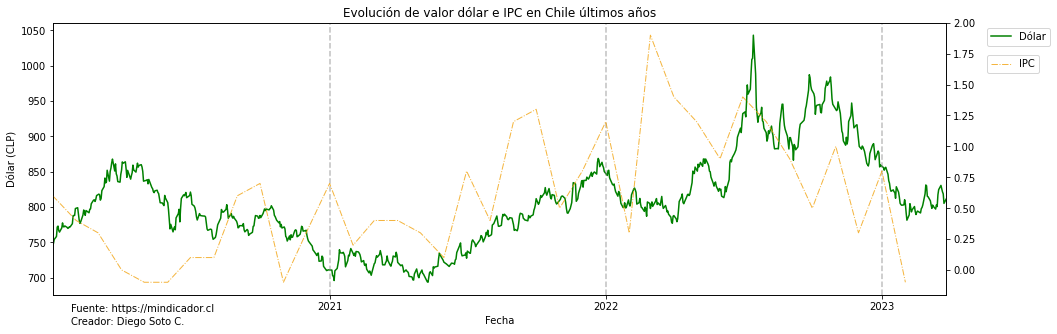

In [69]:
# Creación de df y ordenamiento de datos en base a la fecha
df_dolar = df_indicadores[df_indicadores['indicador'] == 'dolar']
df_ipc = df_indicadores[df_indicadores['indicador'] == 'ipc']
df_dolar = df_dolar.sort_values(by='fecha')
df_ipc = df_ipc.sort_values(by='fecha')

# Creación de gráfico para dólar e ipc
fig, ax = plt.subplots(figsize=(16, 5))
ax2 = ax.twinx()
ax.plot(df_dolar['fecha'], df_dolar['valor'], '-', label='Dólar', color='green')
ax2.plot(df_ipc['fecha'], df_ipc['valor'], label='Inflación', linewidth=1, linestyle='-.', color='#F2A30F', alpha=0.8)
ax.set_xlim(df_dolar['fecha'].min(), df_dolar['fecha'].max()) # Solo se limita el dólar ya que ipc tiene menos valores y mostraría resultados incorrectos
fig.set_facecolor('white') # Cambia el color de fondo, esto principalmente para cuando se guarde el png

# Título y etiquetas
ax.set_title('Evolución de valor dólar e IPC en Chile últimos años')
ax.set_xlabel('Fecha')
date_range = pd.date_range(start=df_dolar['fecha'].min(), end=df_dolar['fecha'].max(), freq='YS')
ax.set_xticks(date_range)
ax.set_xticklabels(date_range.year)
ax.set_ylabel('Dólar (CLP)')
ax.legend(['Dólar'], loc='upper left', bbox_to_anchor=(1.04, 1))
ax2.legend(['IPC'], loc='upper left', bbox_to_anchor=(1.04, 0.9))
ax.text(0.18, -0.05, 'Fuente: https://mindicador.cl', transform=ax.transAxes, horizontalalignment='right', verticalalignment='center', fontsize=10)
ax.text(0.147, -0.1, 'Creador: Diego Soto C.', transform=ax.transAxes, horizontalalignment='right', verticalalignment='center', fontsize=10)

# Las siguientes líneas es para agregar una línea vertical para separar los años
years = range(df_dolar['fecha'].dt.year.min(), df_dolar['fecha'].dt.year.max()+1) # Se adiciona 1 más al rango por el índice de python
for year in years:
    ax.axvline(pd.to_datetime(str(year)+'-01-01'), linestyle='--', color='gray', alpha=0.5)


plt.savefig('assets/EvoluciónDolarIPC.png') # Esto se utiliza para guardar el gráfico, solo se quita de comentario cuando es necesario
# Mostrar el gráfico
plt.show()

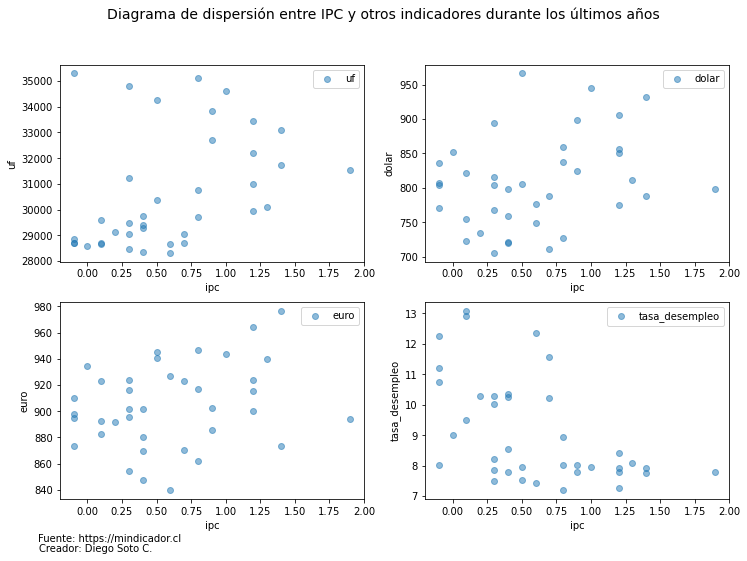

In [85]:
# Copia de df original y limpieza para verificar los datos solo de ipc
df_ipc = df_indicadores_original[df_indicadores_original['indicador'] == 'ipc'].copy().reset_index()
df_ipc = df_ipc.drop(['indicador', 'index'], axis=1)
df_ipc = df_ipc.rename(columns={'valor': 'ipc'})
df_ipc['fecha'] = pd.to_datetime(df_ipc['fecha'].dt.date)
# Creación de df fechas con el máximo y mínimo de ipc, esto con el fin que en el siguiente for, pueda completar los registros faltantes en algunas fechas
fechas = pd.date_range(start=df_ipc['fecha'].min(), end=df_ipc['fecha'].max())
df_fechas = pd.DataFrame({'fecha': fechas})

# Crear el grid de subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Las siguientes líneas se utilizan para recorrer sobre la lista indicadores, sin contabilizar ipc
indicadores_s_ipc = indicadores.copy()
indicadores_s_ipc.remove('ipc')
# El siguiente for recorrerá 2 variables, la primera de ellas es solo a modo de "contador" para iterar sobre el indice de python, así poder crear los gráficos, la variable i es para la lista de indicadores
for c, i in enumerate(indicadores_s_ipc):
    # Como ya está el indicador de ipc, antes de recorrerlo se evalúa, en el caso que esté, lo salta
    # if i == 'ipc':
    #     continue
    # Lo siguiente es para crear un df por indicador sigue el mismo criterio de limpieza del df ipc
    df_i = df_indicadores_original[df_indicadores_original['indicador'] == i].copy().reset_index()
    df_i = df_i.drop(['indicador', 'index'], axis=1)
    df_i = df_i.rename(columns={'valor': i})
    df_i['fecha'] = pd.to_datetime(df_i['fecha'].dt.date)

    # Se crea un join con el df fechas creado anteriormente para obtener los datos más aproximados de las fechas
    df_aux = pd.merge(df_fechas, df_i, on='fecha', how='left')
    # Lo siguiente es para rellenar los campos vacíos con el valor más cercano antes de hacer el join con la tabla de ipc
    df_aux = df_aux.ffill() # Primero rellena todo hacia abajo
    df_aux = df_aux.bfill() # Para los casos en que la primera fila quede con NaN, se rellena hacia arriba
    df_final = pd.merge(df_ipc, df_aux, on='fecha', how='left')
    #print(df_final['ipc']), print(df_final[i])
    ax = axs[c // 2][c % 2]  # Accede a cada subplot, con [c // 2] busca el número truncado de la división del recorrido en "c", con [c % 2] se accede al resto de la división, así crea el eje [0,0][0,1] primero, y luego a [1,0] y [1,1]
    ax.scatter(df_final['ipc'], df_final[i], alpha=0.5, label=i)
    ax.set_xlabel('ipc')
    ax.set_ylabel(i)
    ax.legend()
fig.suptitle('Diagrama de dispersión entre IPC y otros indicadores durante los últimos años', fontsize=14)
fig.set_facecolor('white') # Cambia el color de fondo, esto principalmente para cuando se guarde el png

ax.text(-0.8, -0.2, 'Fuente: https://mindicador.cl', transform=ax.transAxes, horizontalalignment='right', verticalalignment='center', fontsize=10)
ax.text(-0.897, -0.25, 'Creador: Diego Soto C.', transform=ax.transAxes, horizontalalignment='right', verticalalignment='center', fontsize=10)
#plt.savefig('assets/DispersiónIPC.png') # Esto se utiliza para guardar el gráfico, solo se quita de comentario cuando es necesario
plt.show()
# Es probable que, el código hasta aquí se cambie a otro módulo para utilizarlo como función, porque puede servir lo mismo para todos los demás indicadores
#df_ipc.head()